#MSPA PREDICT 420

##Graded Exercise 6: Enron Email

###Introduction

This document presents the results of the sixth graded exercise for the Masters of Science in Predictive Analytics course: PREDICT 420. This assessment required the student to retrieve Enron email records from a MonogoDB database, and perform some exploratory analysis on that data.

###Assessment

####1. Loading the Data

Connect to the MonogoDB database.

In [1]:
#!pip install pymongo
#from __future__ import division, print_function
from pymongo import MongoClient

my_netid = "xxx"
my_password = "xxx"

try:
    client = MongoClient("129.105.208.225")
    client.enron.authenticate(my_netid, 
                              my_password, 
                              source = "$external", 
                              mechanism = "PLAIN")
    print("Connected to MongoDB enron database")
    success = True
except:
    print("Unable to connect to the enron database")

Connected to MongoDB enron database


Retrieve collections contained within the database.

In [2]:
print("Collections in the enron database:")
cols = client.enron.collection_names()
for col in cols:
    print(col)

Collections in the enron database:
pilot
system.indexes
mbox
messages


Count the number of documents within the "messages" collection, and retrieve one example document.

In [3]:
workdocs = client.enron.messages
print("Number of documents:", workdocs.count())
print("One such document:", workdocs.find_one())

Number of documents: 501513
One such document: {'subFolder': 'notes_inbox', 'headers': {'X-From': 'Michael Simmons', 'X-bcc': '', 'X-To': 'Eric Bass', 'Subject': 'Re: Plays and other information', 'To': 'eric.bass@enron.com', 'Date': 'Tue, 14 Nov 2000 08:22:00 -0800 (PST)', 'From': 'michael.simmons@enron.com', 'Message-ID': '<6884142.1075854677416.JavaMail.evans@thyme>', 'X-cc': ''}, 'mailbox': 'bass-e', 'body': "the scrimmage is still up in the air...\n\n\nwebb said that they didnt want to scrimmage...\n\nthe aggies  are scrimmaging each other... (the aggie teams practiced on \nSunday)\n\nwhen I called the aggie captains to see if we could use their field.... they \nsaid that it was tooo smalll for us to use...\n\n\nsounds like bullshit to me... but what can we do....\n\n\nanyway... we will have to do another practice Wed. night....    and I dont' \nknow where we can practice.... any suggestions...\n\n\nalso,  we still need one  more person...", '_id': ObjectId('4f16fc97d1e2d32371003e

Count how many documents contain the string 'klay@enron.com'.

In [4]:
klay_documents = workdocs.find({"$text":{"$search":".*\"klay@enron.com\"*."}})
klay_documents_count = klay_documents.count()
print("Documents containing the string 'klay@enron.com':", klay_documents_count)

Documents containing the string 'klay@enron.com': 2335


Count how many documents contain the string 'klay@enron.com' within the header or body.

In [5]:
klayhb_documents = workdocs.find({"$or": [{"headers":{"$regex":".*\"klay@enron.com\"*."}},
                                          {"body":{"$regex":".*\"klay@enron.com\"*."}}]})
klayhb_documents_count = klayhb_documents.count()
print("Documents containing the string 'klay@enron.com' in the header or body:", klayhb_documents_count)

Documents containing the string 'klay@enron.com' in the header or body: 6


Select documents which contain the string "klay@enron.com" within the header or body.

In [6]:
selectdocs = list(klay_documents)
print("Type of object selectdocs:", type(selectdocs))
print("Number of items in selectdocs:", len(selectdocs))

Type of object selectdocs: <class 'list'>
Number of items in selectdocs: 2335


'Flatten' the documents and append to list.

In [7]:
list_of_emails_dict_data = []
for message in selectdocs:
    tmp_message_flattened_parent_dict = message
    tmp_message_flattened_child_dict = message["headers"]
    del tmp_message_flattened_parent_dict["headers"]
    del tmp_message_flattened_parent_dict["_id"]
    tmp_message_flattened_parent_dict.update(tmp_message_flattened_child_dict)
    list_of_emails_dict_data.append(tmp_message_flattened_parent_dict.copy())

Convert flattened data to pandas dataframe.

In [8]:
import pandas as pd

df_enron_email = pd.DataFrame(list_of_emails_dict_data)
print("Type of object df_enron_email", type(df_enron_email))

Type of object df_enron_email <class 'pandas.core.frame.DataFrame'>


Pickle and re-read the pandas dataframe.

In [4]:
import pickle
import pandas as pd

#df_enron_email.to_pickle("data/enronmail.p")
df_enron_email = pd.read_pickle("data/enronmail.p")

####2. Pre-process the Data

Replace NaN with blanks.

In [5]:
df_enron_email.fillna("", inplace = True)

Convert strings in date column to appropriate format.

In [6]:
from datetime import datetime

def convert_date_string (date_string):
    try:
        return(datetime.strptime(str(date_string)[:16].\
            lstrip().rstrip(), "%a, %d %b %Y"))
    except:
        return(None)

df_enron_email["Date"] = df_enron_email["Date"].apply(lambda d: convert_date_string(d))

Print first five records of dataframe.

In [7]:
df_enron_email.head(5)

,Date,From,Message-ID,Subject,To,X-From,X-To,X-bcc,X-cc,body,mailbox,subFolder
0,2002-01-30,thorsing@mctcnet.net,<3888211.1075860818673.JavaMail.evans@thyme>,Demand Ken Lay Donate Proceeds from Enron Stoc...,klay@enron.com,"""thorsing@mctcnet.net"" <thorsing@mctcnet.net>@...",klay@enron.com,,,"Dean Muesing\n120 Chaucer Ct.\nMankato, MN\nth...",lay-k,deleted_items
1,2002-01-30,jmagi@aol.com,<372437.1075860813437.JavaMail.evans@thyme>,Demand Ken Lay Donate Proceeds from Enron Stoc...,klay@enron.com,"""jmagi@aol.com"" <jmagi@aol.com>@ENRON",klay@enron.com,,,Rev. John Magisano\n605 East 14th Street\nNew ...,lay-k,deleted_items
2,2001-09-28,doyle@rff.org,<5068755.1075852811539.JavaMail.evans@thyme>,RFF Board Meeting,"darius.gaskins@verizon.net, bgrady@carlylesf.c...","""Doyle, Susan"" <Doyle@rff.org>@ENRON <IMCEANOT...",Darius Gaskins (E-mail) <darius.gaskins@verizo...,,"Julie_A._Spellman@sonnenschein.com, jsantos@ca...","Hello everyone,\n\nI am writing to confirm you...",lay-k,inbox
3,2000-10-13,counciloftheamericas@as-coa.org,<30632266.1075840216148.JavaMail.evans@thyme>,Program reminder - Hector Ciavaldini,klay@enron.com,counciloftheamericas@as-coa.org,klay@enron.com,,,- CiavaldiniReminder.doc,lay-k,all_documents
4,2000-10-31,muaa@mizzou.com,<7988015.1075840270070.JavaMail.evans@thyme>,Bayou City Mizzou Casual Conversation,klay@enron.com,<muaa@mizzou.com>,<klay@enron.com>,,,It is time to get together again. November 2nd...,lay-k,notes_inbox


####3. Exploratory Analysis

Count the number of emails which are 'To:' Ken Lay.

In [13]:
emails_to_klay = len(df_enron_email[(df_enron_email["To"].str.contains(".*klay@enron.com*."))])
print("Number of emails 'to' Ken Lay:", emails_to_klay)

Number of emails 'to' klay: 1955


Count the number of emails which are 'From:' Ken Lay.

In [14]:
emails_from_klay = len(df_enron_email[(df_enron_email["From"].str.contains(".*klay@enron.com*."))])
print("Number of emails 'from' Ken Lay:", emails_from_klay)

Number of emails 'from' klay: 0


Count the number of emails which Ken Lay was 'ccd'.

In [15]:
emails_cc_klay = len(df_enron_email[(df_enron_email["X-cc"].str.contains(".*klay@enron.com*."))])
print("Number of emails 'ccd' to Ken Lay:", emails_cc_klay)

Number of emails 'ccd' to klay: 55


Count the number of emails which Ken Lay was 'bccd'.

In [16]:
emails_bcc_klay = len(df_enron_email[(df_enron_email["X-bcc"].str.contains(".*klay@enron.com*."))])
print("Number of emails 'bccd' to Ken Lay:", emails_bcc_klay)

Number of emails 'bccd' to klay: 0


Count who sent Ken Lay the most emails.

In [9]:
df_temp = df_enron_email
df_temp["Count"] = 1
df_temp = df_temp[(df_enron_email["To"].str.contains(".*klay@enron.com*."))]
number_to_klay = df_temp.groupby(["From"])["Count"].sum()
number_to_klay = number_to_klay.sort_values(ascending = False)
print("User who sent the most emails to Ken Lay:", number_to_klay.index[0])
print("Number of emails sent by", number_to_klay.index[0], "to Ken Lay:", number_to_klay[0])

User who sent the most emails to Ken Lay: savont@email.msn.com
Number of emails sent by savont@email.msn.com to Ken Lay: 54


Count the volume of emails before and after Enron's bankruptcy was declared.

In [18]:
date_min = df_enron_email["Date"].min()
date_max = df_enron_email["Date"].max()

df_temp = df_enron_email
before_bank = df_temp['Date'] <= '2002-01-09'
print("Number of emails before bankruptcy:", before_bank.sum())
after_bank = df_temp['Date'] >= '2002-01-10'
print("Number of emails after bankruptcy:", after_bank.sum())

Number of emails before bankruptcy: 1186
Number of emails after bankruptcy: 1149


Count how many emails mention 'Arthur Andersen', Enron's accounting firm.

In [10]:
import re

df_temp = df_enron_email[["Subject", "body"]]
arthur_count = df_temp.applymap(lambda x: bool(re.search(".*Arthur Andersen*.", x))).any(axis=1)
print("Number of emails which mention Athur Andersen:", arthur_count.sum())

Number of emails which mention Athur Andersen: 3


####3. Undirected Network Graph

Construct an undirected network graph with edges showing number of 'to' and 'from' emails exchanged to Ken Lay (note: there were no emails sent from Ken Lay in the dataset).

In [11]:
#source: https://www.udacity.com/wiki/creating-network-graphs-with-python
#source: http://stackoverflow.com/questions/34146265/how-to-add-nodes-and-edges-to-a-network-analysis-graph-in-networkx
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

def draw_graph(graph, labels=None, graph_layout="random",
               node_size=1600, node_color="blue", node_alpha=0.3,
               node_text_size=12,
               edge_color="blue", edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font="sans-serif"):

    plt.figure(figsize=(15,15))
    
    G=nx.Graph()

    for edge in graph:
        G.add_edge(edge[0], edge[1])
        
    if graph_layout == "spring":
        graph_pos=nx.spring_layout(G)
    elif graph_layout == "spectral":
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == "random":
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)

    if labels is None:
        labels = range(len(graph))

    edge_labels = dict(zip(graph, labels))
    nx.draw_networkx_edge_labels(G, graph_pos, edge_labels=edge_labels, 
                                 label_pos=edge_text_pos)

    plt.show()

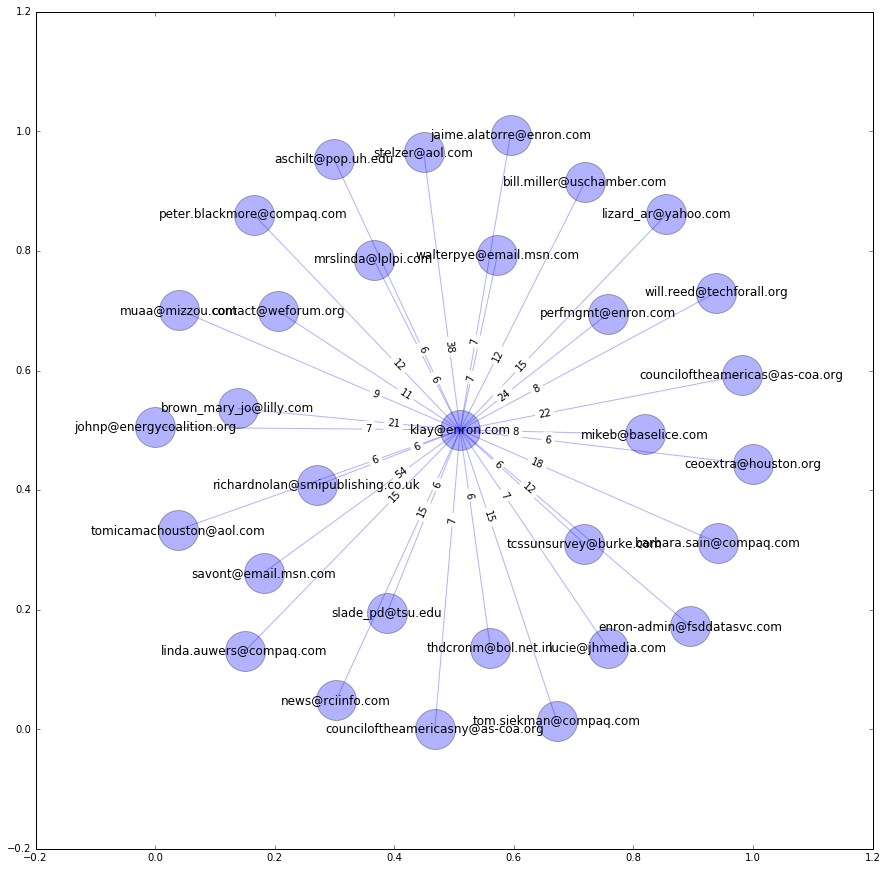

In [12]:
df_klay_emails = pd.DataFrame(number_to_klay)
df_klay_emails["From"] = df_klay_emails.index
df_klay_emails["To"] = "klay@enron.com"
df_klay_emails = df_klay_emails[:30] # Limit to 30 records.

list_klay_emails = list(df_klay_emails[["From", "To"]].values.tolist())
tuple_klay_emails = [tuple(l) for l in list_klay_emails]

labels = df_klay_emails["Count"].tolist()
draw_graph(tuple_klay_emails, labels, "spring")